In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import scipy.linalg
import logging
import plotly.graph_objs as go
import plotly.express as px
import tensorflow as tf

In [3]:
def plot_3d_function(f, a = 10, k = 100):
    x = np.linspace(-a, a, k)
    y = x.copy()
    xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    z = f(xy)
    fig = go.Figure(data=[go.Surface(x = x,  y= y, z=z.reshape((x.shape[0], -1)))])
    fig.update_layout(title = f.__name__, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

# Funkcje celu

In [4]:
def sphere_function(X):
    return np.sum(X**2, axis=1)

In [6]:
def ellipsoid_function(X, a=2):
    n = X.shape[-1]
    return np.sum((a**(np.arange(n)/(n-1)))*X**2, axis=1)

In [8]:
def rastrigin_function(X):
    return 10.0 * X.shape[1] + np.sum(X**2, axis=1) - 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [10]:
def schwefel_function(X):
    return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [12]:
def griewank_function(X):
    return 1 + np.sum(X**2 / 4000, axis=1) - np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [14]:
def cigar_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = X[:,0]**2
    x2 = np.sum(a*X[:,1:]**2, axis = 1)
    return x1+x2

In [16]:
def discus_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [18]:
def cigar_discus_function(X, a = 2):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum((a**0.5)*X[:,1:-1]**2, axis = 1)
    x3 = X[:,-1]**2
    return x1+x2+x3

In [20]:
def parab_ridge_function(X):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = - X[:,0]
    x2 = 100*np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [22]:
def two_axes_function(X, a = 5):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    n = X.shape[-1]
    k = n//2
    x1 = np.sum(a*X[:,:k]**2, axis = 1)
    x2 = np.sum(X[:,k:]**2, axis = 1)
    return x1+x2

# Implementacja CMA-ES

In [ ]:
class CMA_ES:
    def __init__(self, x0, sigma, maxfevals = 10000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        self.shape = tf.cast((self.lam, N), tf.int32)
        
        if weights:
            self.weights = weights
        else:
            self.weights = np.array([np.log(self.lam / 2 + 0.5) - np.log(i + 1) if i < self.mu else 0
                        for i in range(self.lam)])
            self.weights /= np.sum(self.weights)
        if(self.weights.shape == (self.lam,)):
            self.weights = self.weights[:, np.newaxis]
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        # self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.cmu = 2 * (self.mueff - 2 + 1 / self.mueff) / ((N + 2)**2 + 2 * self.mueff / 2)
        # self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs
        self.damps = 1 + 2 * max(0, np.sqrt((self.mueff - 1)/(N + 1)) - 1) + self.cs

        self.xmean = np.array(x0[:])
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps =np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = []   
        self.best = (x0, None)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.ones(N)
        self.B = np.eye(self.dimension)
        self.D = np.eye(self.dimension)

    def _update_eigensystem(self, current_eval, lazy_gap_evals):
        if current_eval <= self.updated_eval + lazy_gap_evals:
            return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        z = tf.random.normal(self.shape, dtype=tf.float64)
        z = np.array(z)
        y = z @ (self.B @ self.D)
        x = self.xmean + self.sigma * y
        return x
    
    def update(self, x, fitvals):
        """Zaktualizuj wartoĹci uzyskanych parametrĂłw"""
        self.counteval += fitvals.shape[0] 
        
        #------------------------------------------------------------------------------------------------------
        idx = np.argsort(fitvals)
        x_sorted = x[idx]
        self.fitvals = fitvals[idx] 
        self.best = (x[0], self.fitvals[0])
        taken = x_sorted[:self.mu]

        xdiff = x_sorted - self.xmean
        x_mean = np.sum(xdiff * self.weights, axis=0)
        m = self.xmean + x_mean
        #------------------------------------------------------------------------------------------------------
        y_mean = x_mean / self.sigma 
        pc = (1 - self.cc) * self.pc + np.sqrt(self.cc * (2 - self.cc) * self.mueff) * y_mean
        pcmatrix = pc[:, np.newaxis]

        C_m = np.array([e[:, np.newaxis] * e.T for e in (xdiff / self.sigma)])
        y_s = np.sum(C_m * self.weights[:, np.newaxis], axis=0)

        C = (1 - self.c1 - self.cmu) * self.C + self.c1 * pcmatrix * pcmatrix.T + self.cmu * y_s

        C = (C + C.T)/2.0
        
        #--------------------------------------------------------------------------------------------------------

        D_inv = np.diag(np.reciprocal(np.diag(self.D)))
        C_inv_squared = (self.B @ D_inv) @ (self.B.T)
        C_inv_squared_y = np.squeeze(C_inv_squared @ y_mean[:, np.newaxis])  
        ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * C_inv_squared_y  

        sigma = self.sigma * np.exp((self.cs / self.damps) * ((np.linalg.norm(ps) / self.chiN) - 1))

        #--------------------------------------------------------------------------------------------------------
        u, B, _ = tf.linalg.svd(C)
        u = np.array(u)
        B = np.array(B)
        diag_D = np.sqrt(u)
        D = np.diag(diag_D)

        #--------------------------------------------------------------------------------------------------------

        self.pc = pc
        self.ps = ps
        self.C = C
        self.sigma = sigma
        self.B = B
        self.D = D
        self.xmean = m
        return taken
        
    def terminate(self):
        """ZakoĹcz algorytm"""
        if self.counteval <= 0:
            return False
        if self.counteval >= self.maxfevals:
            return True
        if self.condition_number > 1e13:
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            return True
        return False

In [ ]:
def optimize(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    cntr = 0
    while not cma_es.terminate():
        cntr+=1
        x = cma_es.sample()
        f_eval = func(x)
        cma_es.update(x, f_eval)
        res.append(cma_es.best)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res

In [59]:
def optimize_and_plot(f, sigma = 1, d = 10, popsize = None, maxfevals = 1000):
    x0 = np.repeat(100.0, d)
    res = optimize(f, x0, sigma, popsize = popsize, maxfevals = maxfevals)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])
    fig = px.line(x = np.arange(y.shape[0]) + 1, y = y)
    fig.show()

# Ewaluacja CMA-ES

In [42]:
optimize_and_plot(sphere_function, d = 2)

Popsize: 6
Iteration   100: 1.8910421396340606e-12
Best: [ 2.35668754e-13 -9.01620180e-13], value: 1.7766694191373594e-25


In [43]:
optimize_and_plot(sphere_function, sigma = 200)

Popsize: 10
Iteration   100: 0.04035092403093894
Best: [-0.07801654 -0.03188491 -0.03880007 -0.07160591  0.01017654  0.13004169
  0.02338422 -0.16726741  0.15378692  0.04660892], value: 0.04035092403093894


In [44]:
optimize_and_plot(sphere_function)

Popsize: 10
Iteration   100: 0.7731058810838247
Best: [ 0.00118371  0.50169407  0.08262018 -0.16819054  0.58870106 -0.02693545
 -0.52534413  0.51168203 -0.20261669  0.33472738], value: 0.7731058810838247


In [45]:
optimize_and_plot(ellipsoid_function)

Popsize: 10
Iteration   100: 6.646095043834315
Best: [ 1.02297648 -0.9687379   0.82251064  0.98096645  1.04713133  1.67723359
  0.3345942   1.18515584  0.07820393 -0.91650597], value: 6.646095043834315


In [46]:
optimize_and_plot(griewank_function)

Popsize: 10
Iteration   100: 0.8120323346907962
Best: [ 0.60070734 -6.05210703 -0.4739492   2.23263708  2.84864324  1.3187598
 -1.45093777  1.28817172  0.34786437 -3.7896981 ], value: 0.8120323346907962


In [60]:
optimize_and_plot(schwefel_function, maxfevals = 10000)

Popsize: 10
Iteration   100: 3553.4848898168248
Iteration   200: 3553.479180487458
Iteration   300: 3553.4791804844554
Iteration   400: 3553.4791804844554
Iteration   500: 3553.4791804844554
Iteration   600: 3553.4791804844554
Iteration   700: 3553.4791804844554
Iteration   800: 3553.4791804844554
Iteration   900: 3553.4791804844554
Iteration  1000: 3553.4791804844554
Best: [65.54786546 65.54786577 65.54786448 65.54786506 65.54786528 65.54786565
 65.54786609 65.54786502 65.54786568 65.54786548], value: 3553.4791804844554


In [61]:
optimize_and_plot(rastrigin_function)

Popsize: 10
Iteration   100: 106.55917479317291
Best: [-2.53122578  0.88357184  1.66086217 -1.85036548 -3.27744611  1.92527528
  0.24045092  0.14308866 -0.44065069  1.35050452], value: 106.55917479317291


In [77]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def optimize_2(func, x0, sigma, maxfevals=1000, popsize=None, weights=None):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    xes = []
    taken_xes = []
    cntr = 0
    while not cma_es.terminate():
        cntr += 1
        x = cma_es.sample()
        f_eval = func(x)
        taken = cma_es.update(x, f_eval)
        taken_xes.append(taken)
        res.append(cma_es.best)
        xes.append(x)
        if cntr % 100 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res, xes, taken_xes

# Function to draw the ellipse representing the 95% probability contour
def plot_ellipse(mean, cov_matrix, ax, color='red', alpha=0.2, label=None):
    eigvals, eigvecs = np.linalg.eig(cov_matrix)
    order = eigvals.argsort()[::-1]  # Sort by eigenvalue, largest first
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(*eigvecs[:, 0][::-1])
    angle = np.degrees(angle)
    if angle < 0:
        angle += 180
    
    # 95% confidence interval ellipse
    v = 2.45  # 95% confidence for 2D normal distribution
    width, height = 2 * v * np.sqrt(eigvals)
    # ellipse = Ellipse(mean, width, height, angle, color=color, alpha=alpha, label=label)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=alpha, label=label)
   
    ax.add_patch(ellipse)
    # buffer = 10  # Extra space around the ellipse
    # ax.set_xlim(mean[0] - (width / 2 + buffer), mean[0] + (width / 2 + buffer))
    # ax.set_ylim(mean[1] - (height / 2 + buffer), mean[1] + (height / 2 + buffer))

def show_for_generation(j, res, xes, taken_xes):
    fig, ax = plt.subplots(figsize=(10, 10))
    this_gen = xes[j]
    next_gen = xes[j + 1]

    taken = taken_xes[j]
    ax.scatter(taken[:, 0], taken[:, 1], color='yellow', label='Survivors')
    
    not_taken = np.array([x for x in this_gen if x not in taken])
    ax.scatter(not_taken[:, 0], not_taken[:, 1], color='black', label='Dead')

    mean_this_gen = np.mean(this_gen, axis=0)
    cov_this_gen = np.cov(this_gen.T)
    plot_ellipse(mean_this_gen, cov_this_gen, ax, color='red', alpha=0.2, label='Generation g')

    mean_next_gen = np.mean(next_gen, axis=0)
    cov_next_gen = np.cov(next_gen.T)
    plot_ellipse(mean_next_gen, cov_next_gen, ax, color='green', alpha=0.2, label='Generation g+1')
    plt.show()
    plt.clf()


def optimize_and_plot_ellipse(f, sigma=1, d=2, popsize=None):
    x0 = np.repeat(100.0, d)
    res, xes, taken_xes = optimize_2(f, x0, sigma, popsize=popsize)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])

    show_for_generation(0, res, xes, taken_xes)
    show_for_generation(20, res, xes, taken_xes)
    show_for_generation(50, res, xes, taken_xes)
    show_for_generation(80, res, xes, taken_xes)
    show_for_generation(99, res, xes, taken_xes)


Popsize: 6
Iteration   100: 1.293114856890353e-13
Best: [3.46281337e-13 5.64007816e-13], value: 5.292781185850198e-26


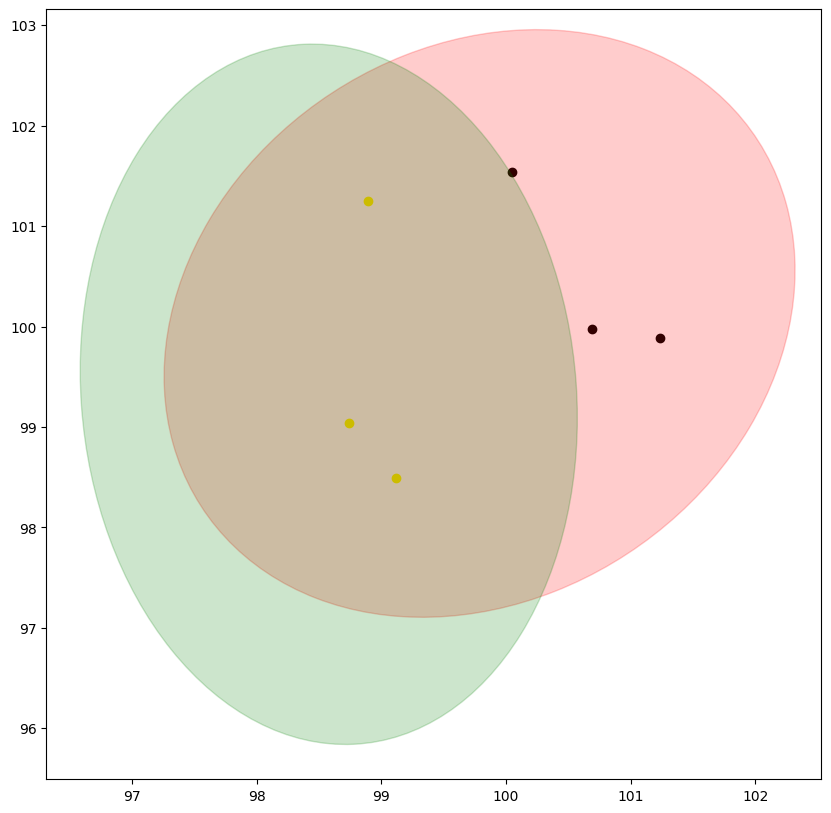

<Figure size 640x480 with 0 Axes>

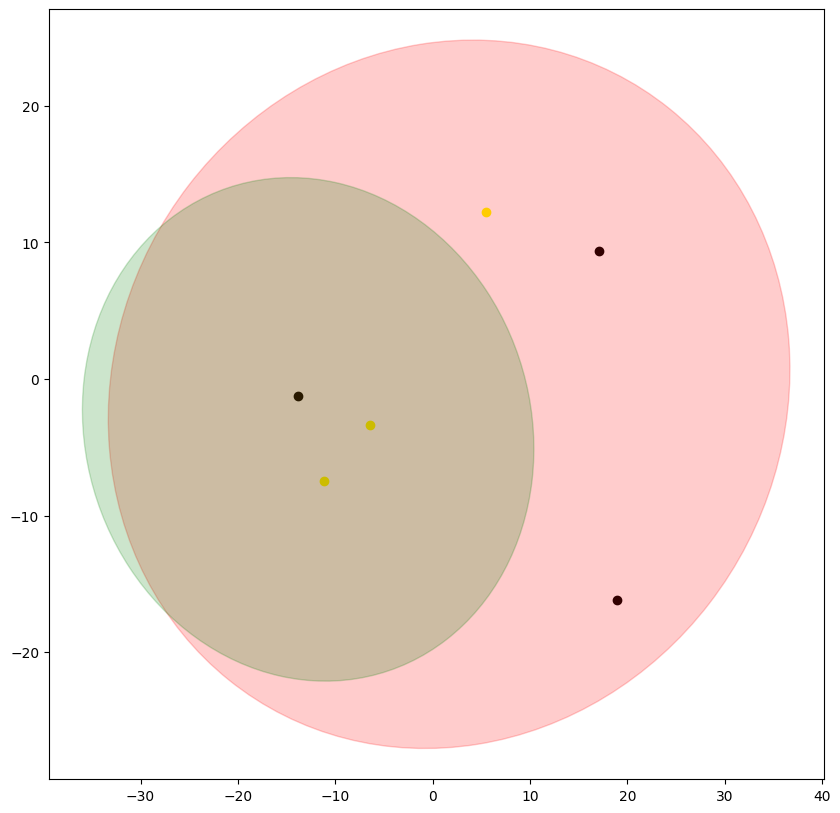

<Figure size 640x480 with 0 Axes>

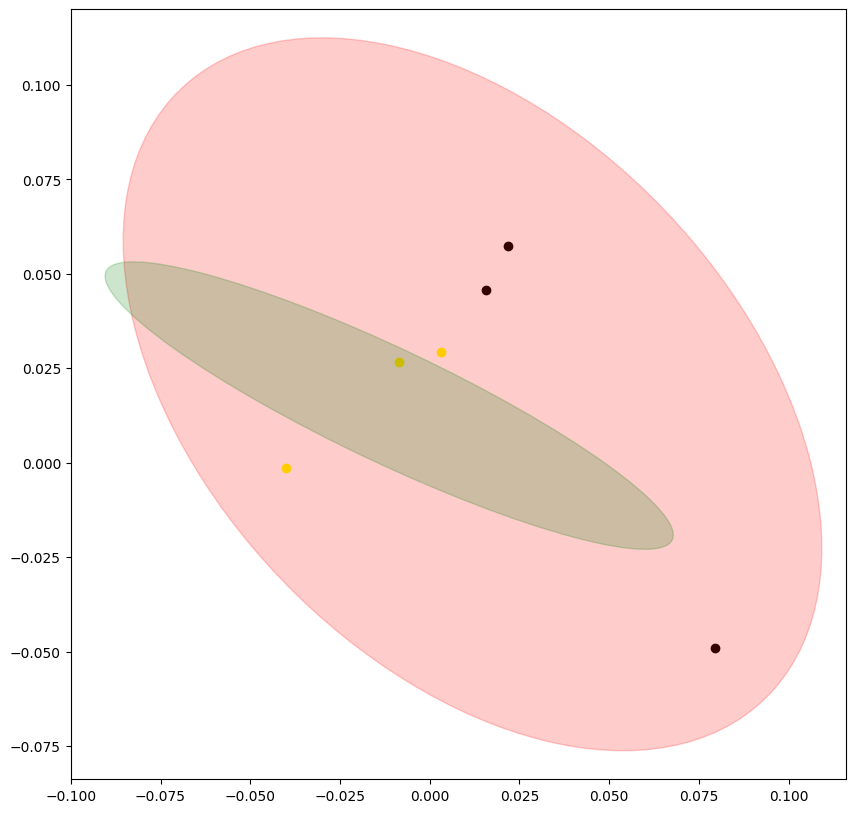

<Figure size 640x480 with 0 Axes>

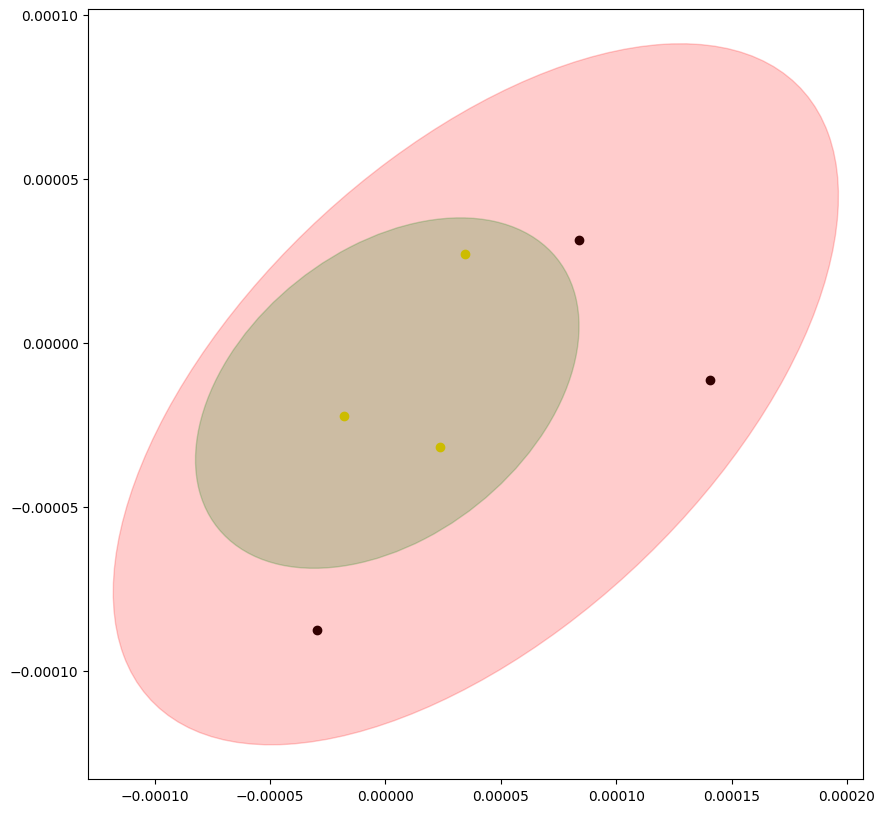

<Figure size 640x480 with 0 Axes>

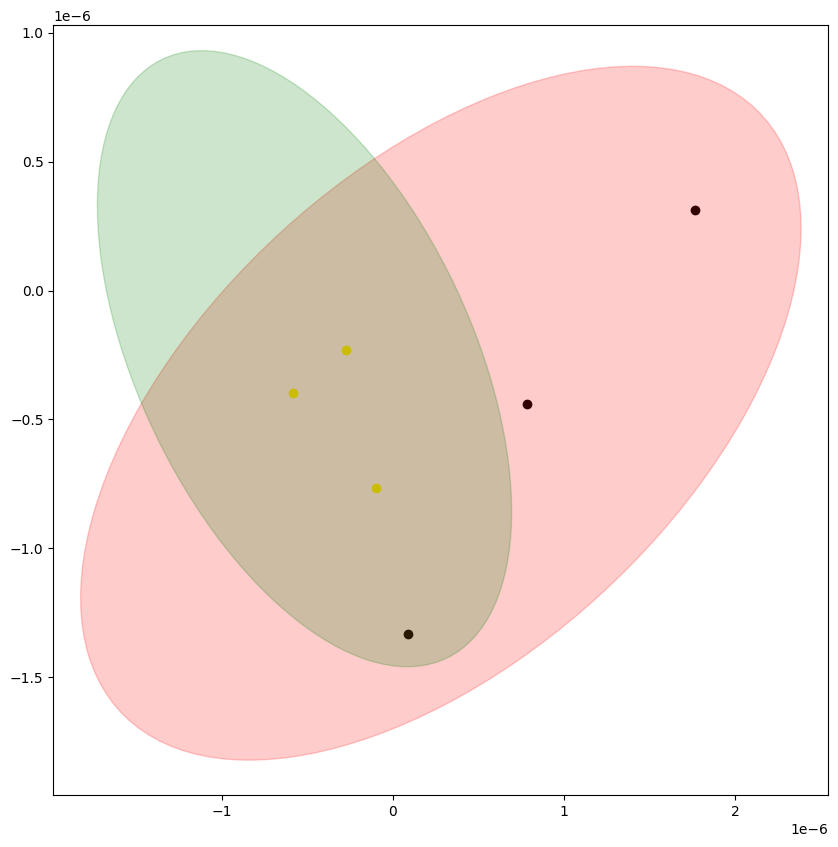

<Figure size 640x480 with 0 Axes>

In [78]:
optimize_and_plot_ellipse(sphere_function)

Popsize: 6
Iteration   100: 7.941751944140175e-13
Best: [-1.59295751e-13  9.30754940e-13], value: 2.624289409009002e-24


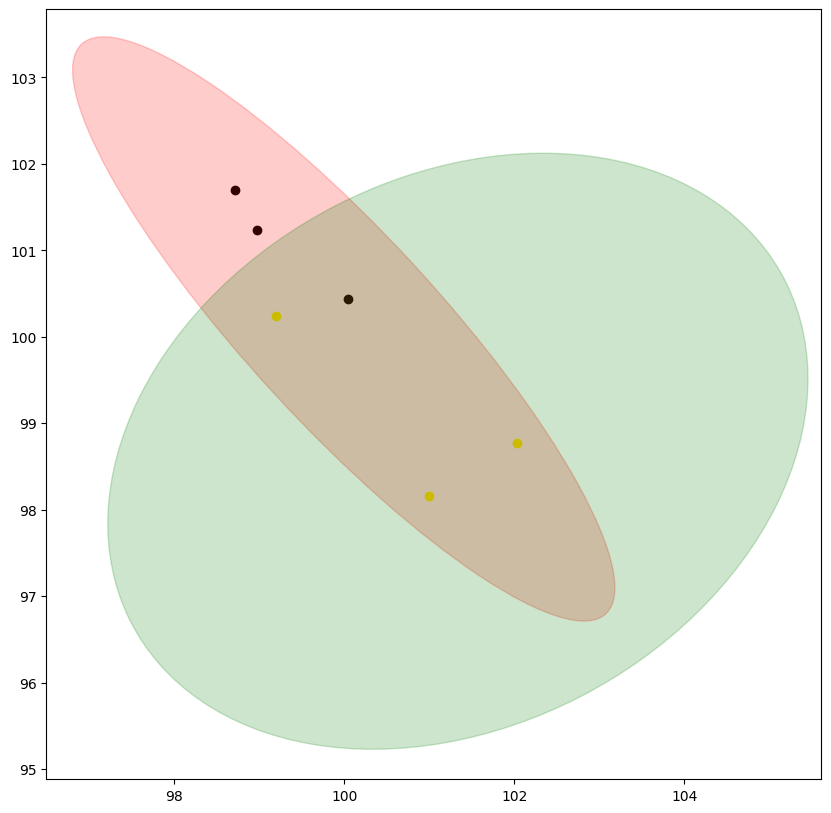

<Figure size 640x480 with 0 Axes>

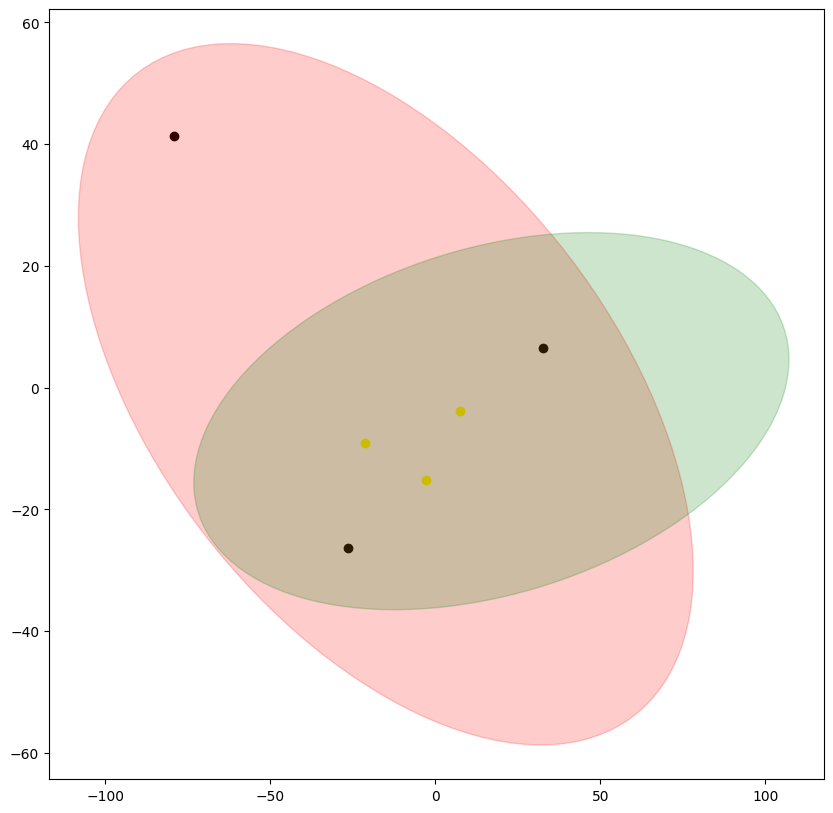

<Figure size 640x480 with 0 Axes>

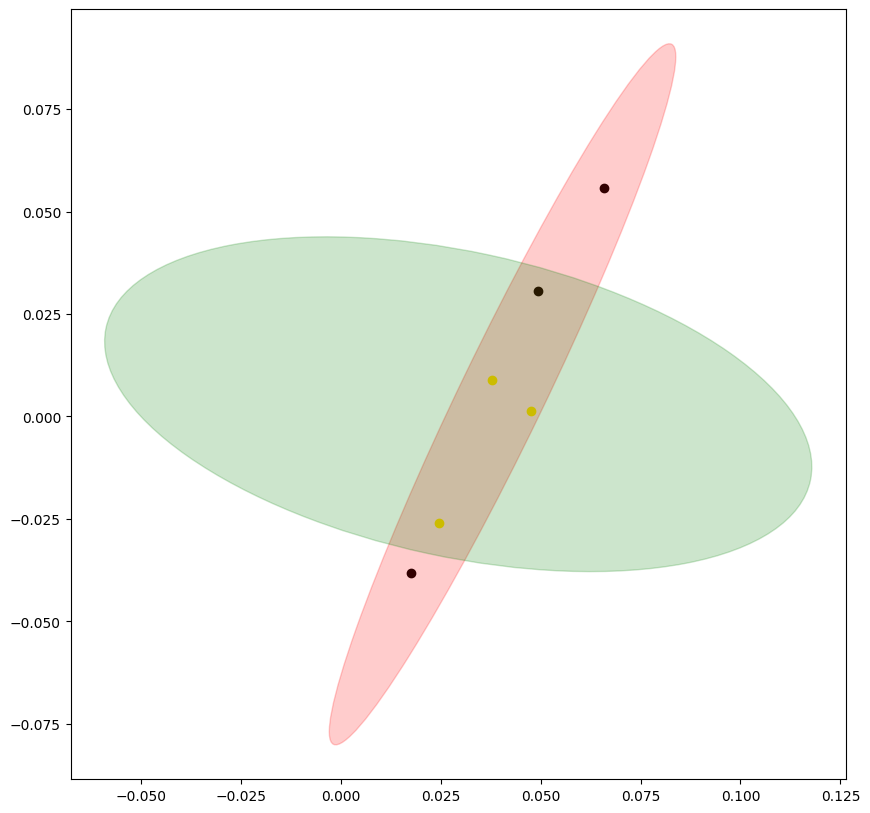

<Figure size 640x480 with 0 Axes>

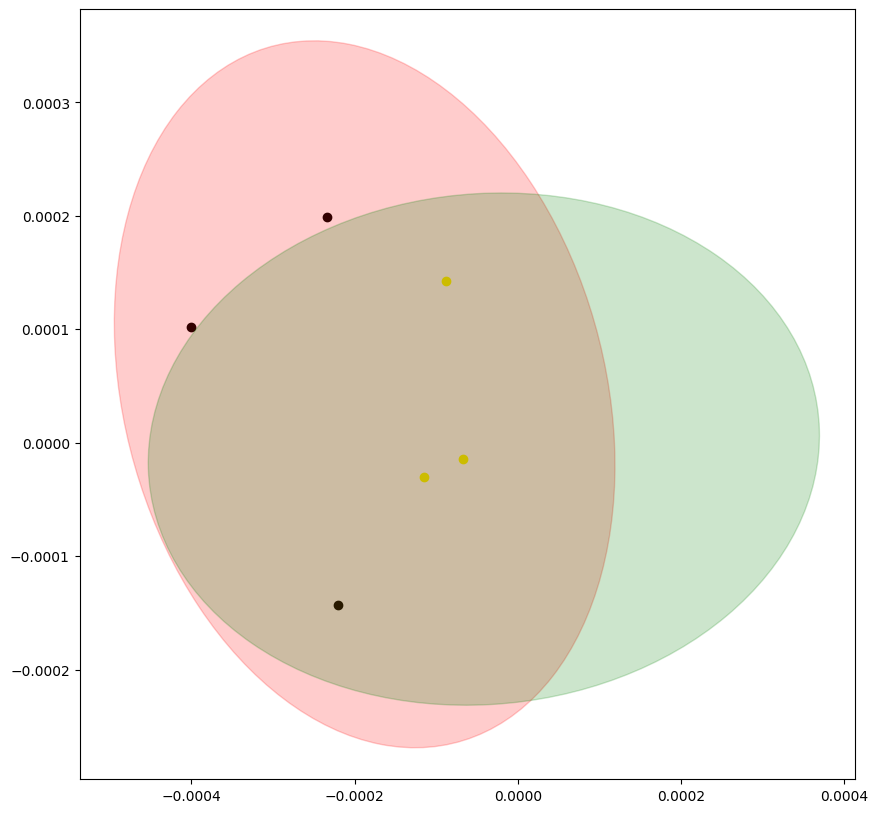

<Figure size 640x480 with 0 Axes>

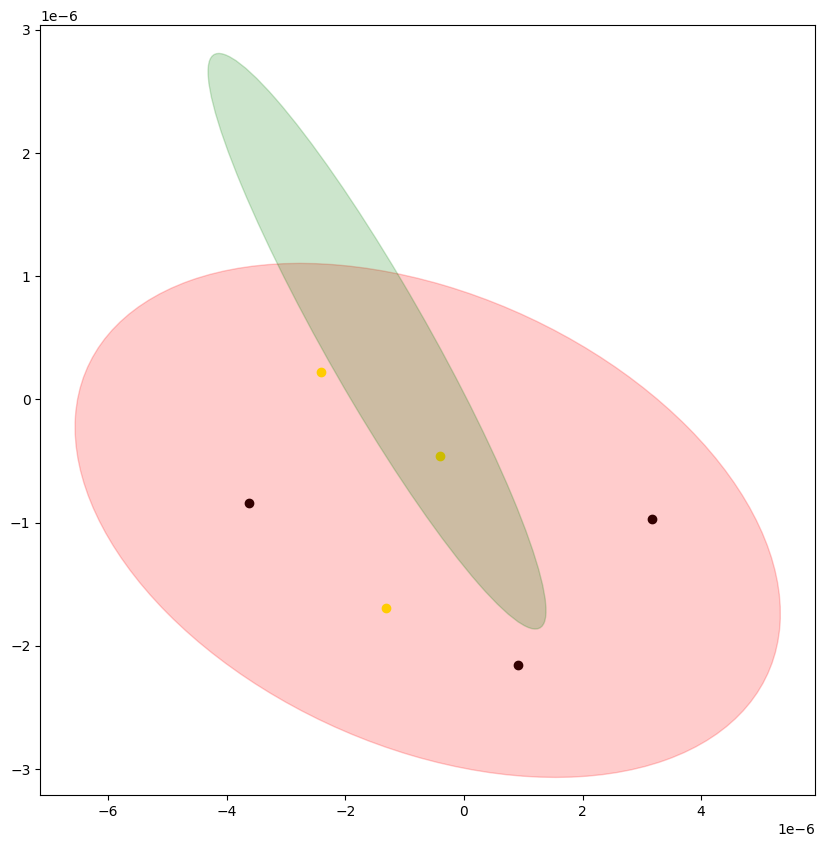

<Figure size 640x480 with 0 Axes>

In [79]:
optimize_and_plot_ellipse(cigar_function)

Popsize: 6
Iteration   100: 3.167615885489472e-16
Best: [-1.49840860e-15  1.57371094e-14], value: 1.9671973480076278e-28


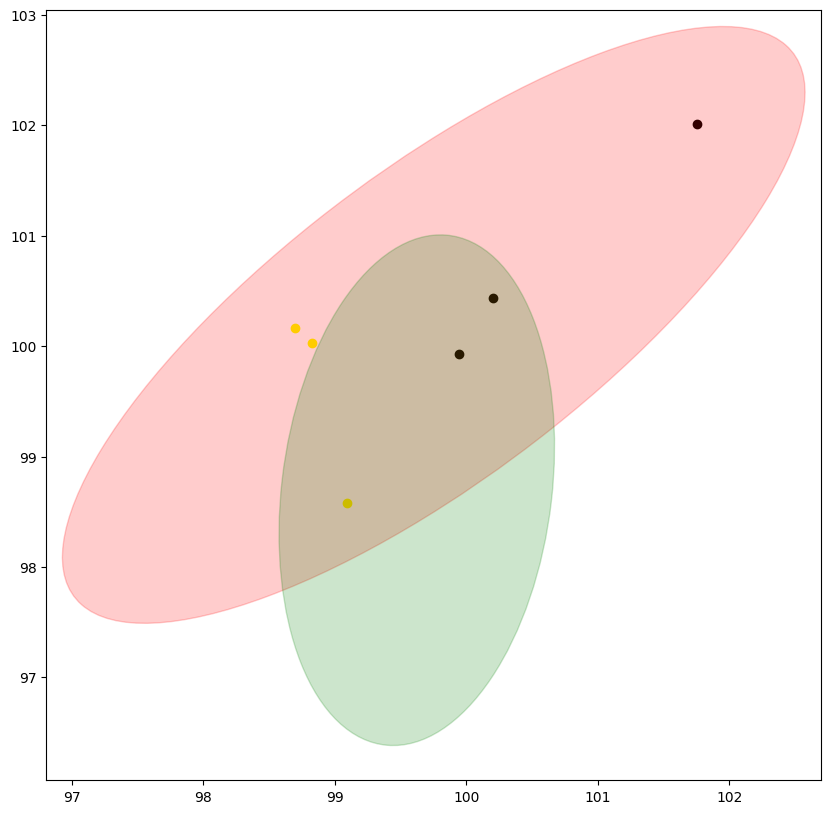

<Figure size 640x480 with 0 Axes>

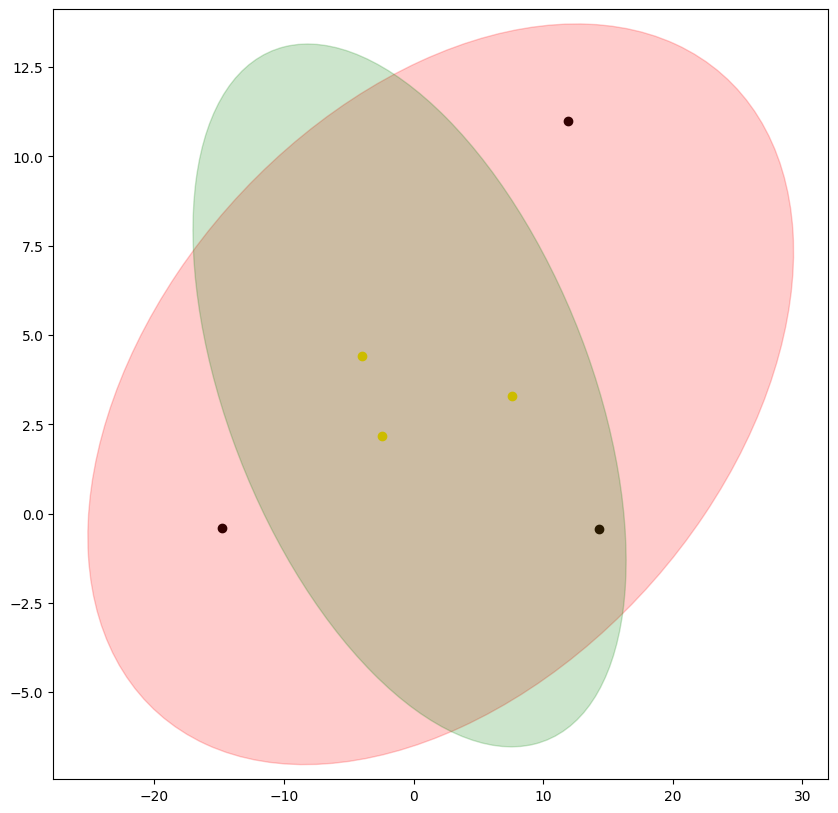

<Figure size 640x480 with 0 Axes>

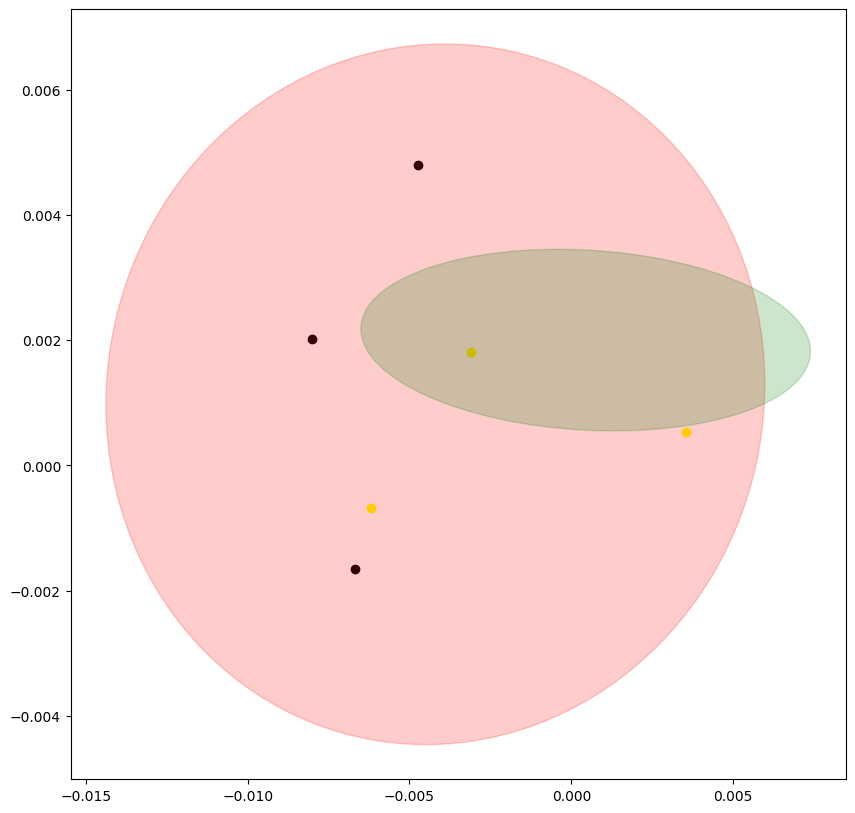

<Figure size 640x480 with 0 Axes>

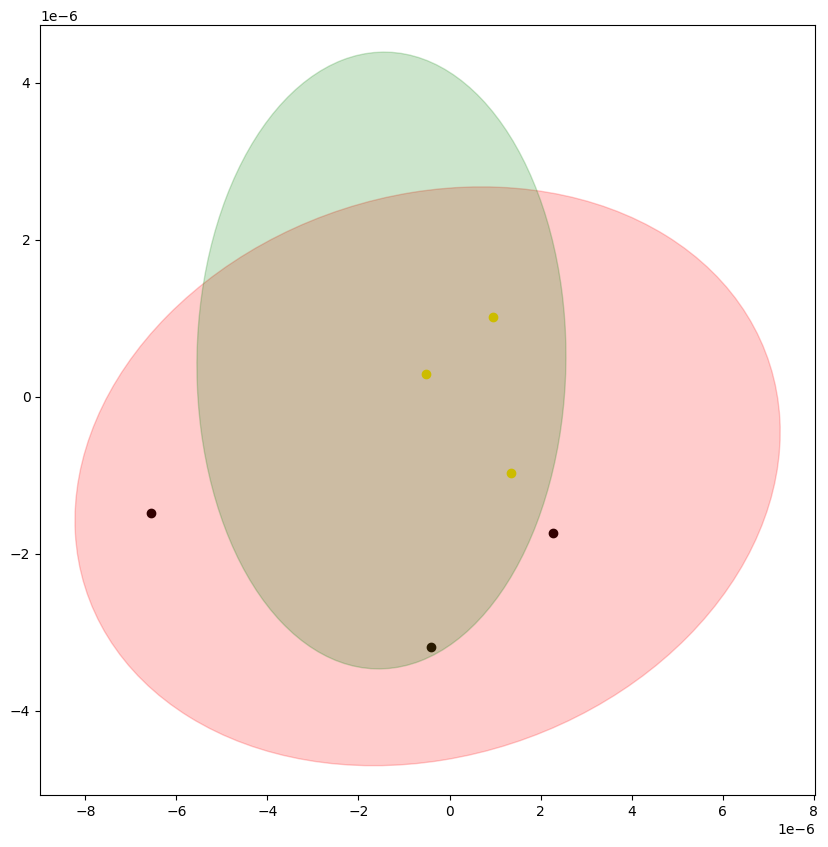

<Figure size 640x480 with 0 Axes>

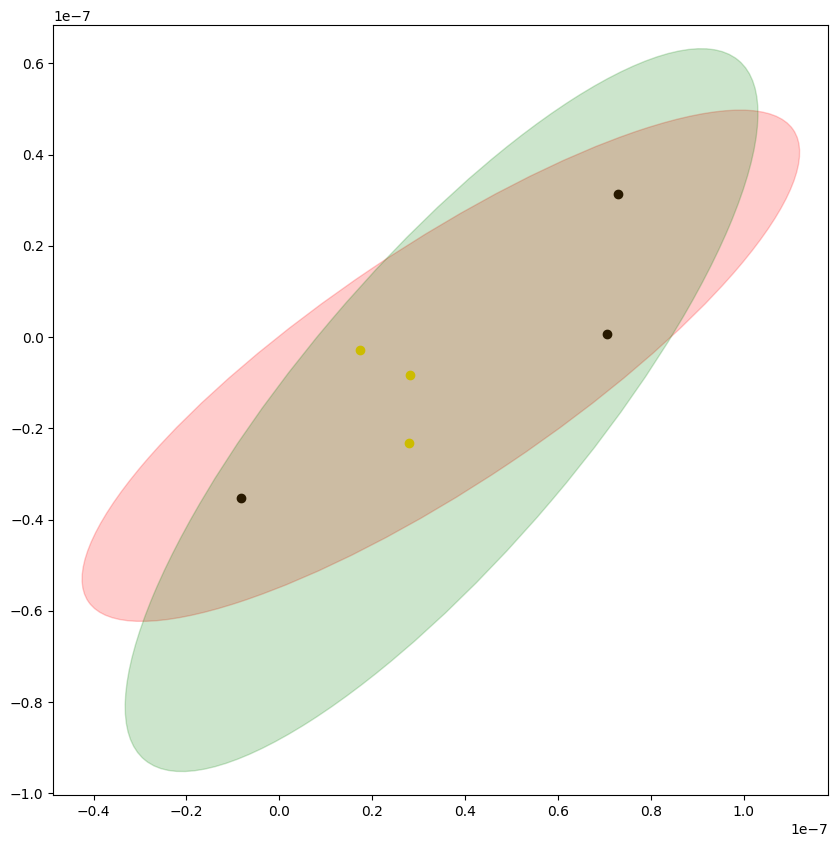

<Figure size 640x480 with 0 Axes>

In [80]:
optimize_and_plot_ellipse(ellipsoid_function)

Popsize: 6
Iteration   100: 0.9949590798243086
Best: [4.45648072e-10 9.94958637e-01], value: 0.9949590570932898


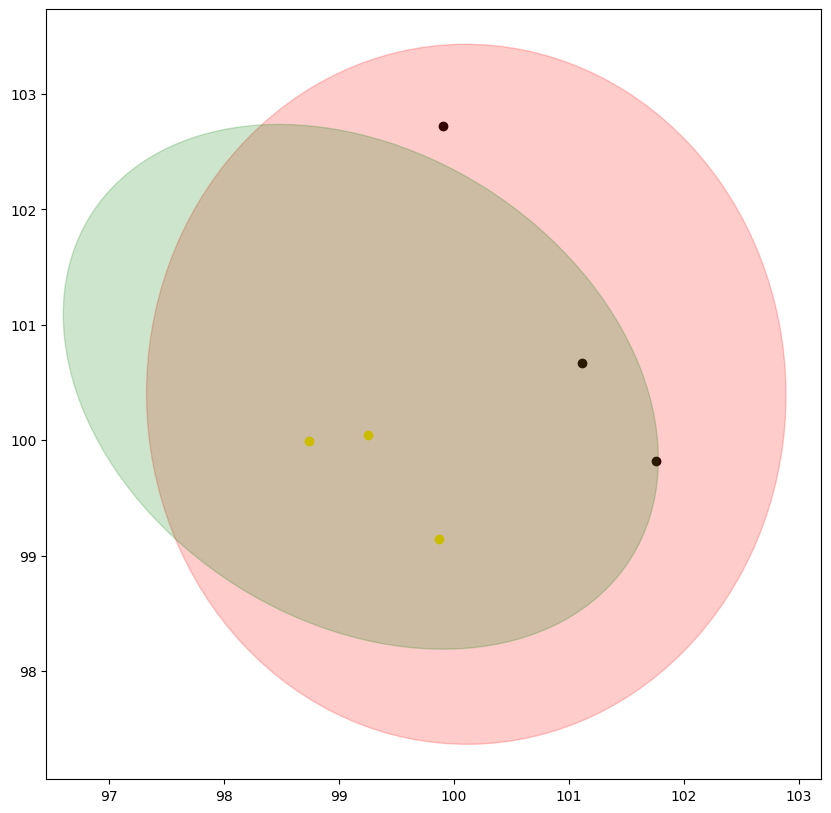

<Figure size 640x480 with 0 Axes>

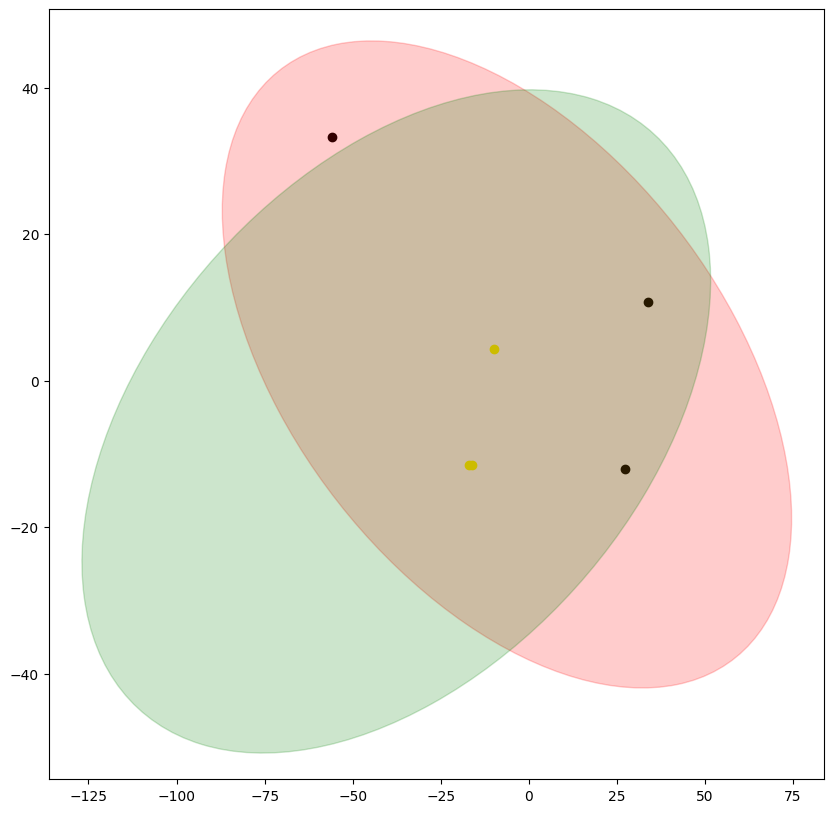

<Figure size 640x480 with 0 Axes>

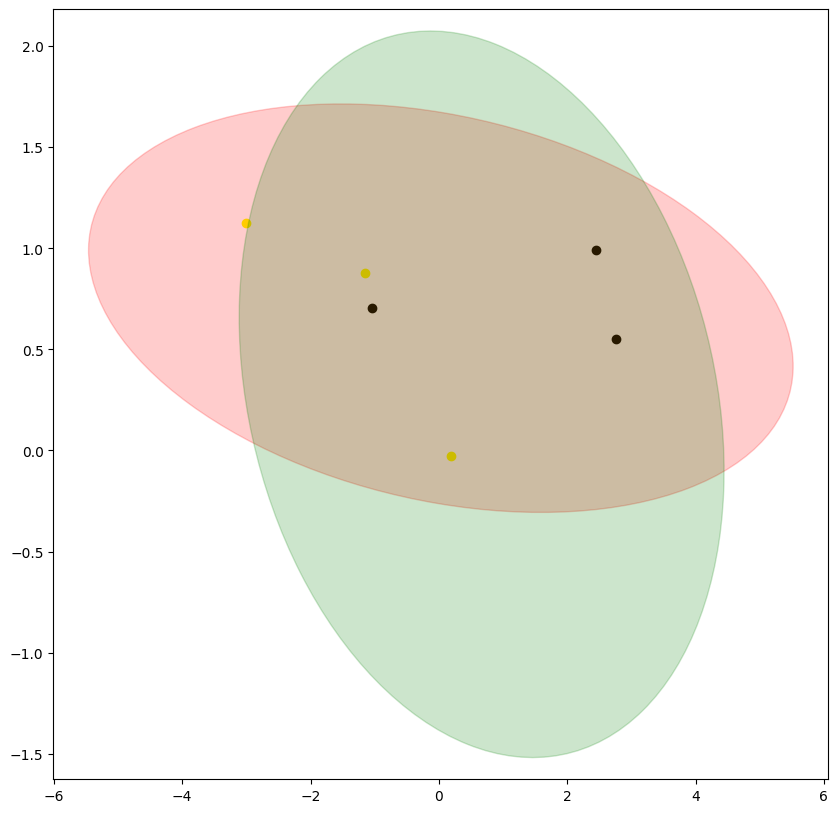

<Figure size 640x480 with 0 Axes>

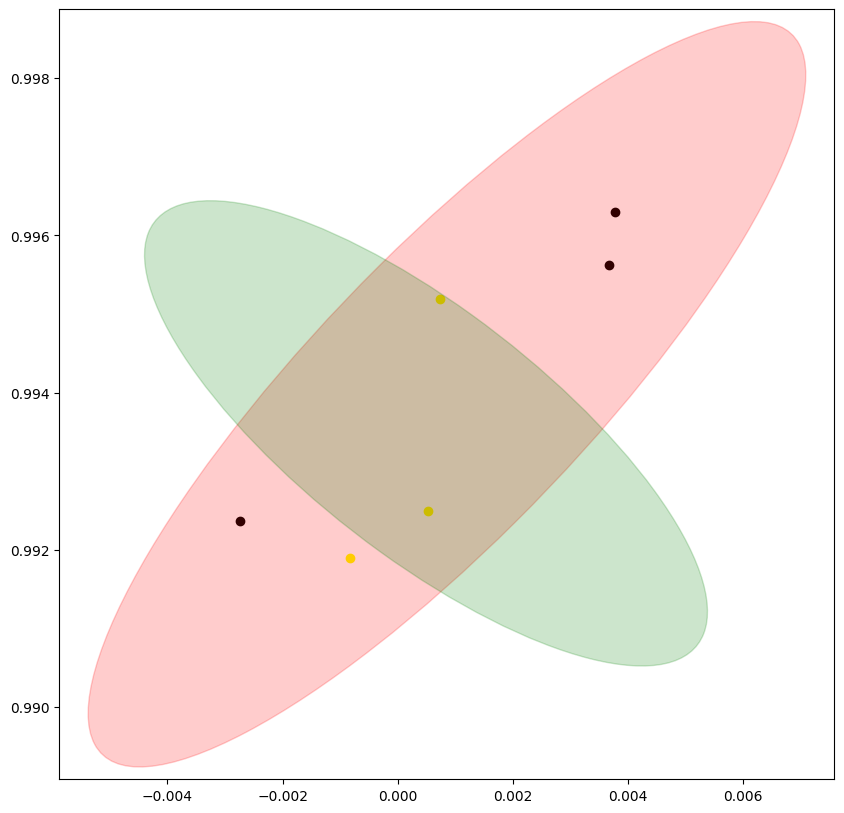

<Figure size 640x480 with 0 Axes>

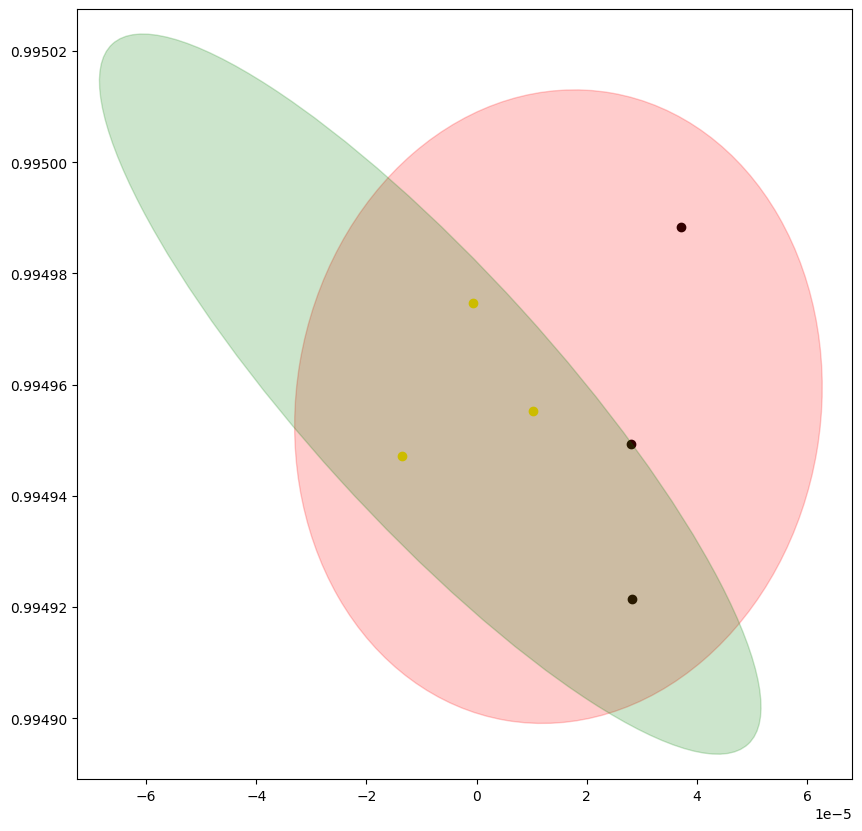

<Figure size 640x480 with 0 Axes>

In [81]:
optimize_and_plot_ellipse(rastrigin_function)